In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff




In [48]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [49]:
train = pd.read_csv('Data/train.csv')
#validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('Data/test.csv')

Looking to our data

In [50]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Maximum nuber of words that can be present in a comment 

In [51]:
train['text'].apply(lambda x:len(str(x).split())).max()


31

Writing a function for getting auc score for validation


In [52]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    #f1_score = metrics.f1_score(target, predictions ) #average="micro" weighted macro
    #accuracy = metrics.accuracy_score(target, predictions)
    return roc_auc


# Data preparation

In [53]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, train.target.values, 
                                                  stratify=train.target.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# 2 Model

## 2-1 RNN

In this project im going to use RNN as my model
Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. 

A recurrent newral network can be thought of as multiple copies of the same network, each passing a message to a successor. This type of flow of information through time (or sequence) in a recurrent neural network is shown in the diagram below, which unrolls the sequence (loop unrolled)

![Alt text](https://miro.medium.com/max/720/1%2As1EGNG54_4j93SCQF-NvKA.webp)

This unrolled network shows how we can supply a stream of data (intimately related to sequences, lists and time-series data) to the recurrent neural network.

## 2-2 Tokenization

In RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1.
What keras Tokenizer does is , it takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now

In [54]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 50

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [55]:
word_index



{'t': 1,
 'co': 2,
 'http': 3,
 'the': 4,
 'a': 5,
 'in': 6,
 'to': 7,
 'of': 8,
 'and': 9,
 'i': 10,
 'is': 11,
 'for': 12,
 'on': 13,
 'you': 14,
 'my': 15,
 'with': 16,
 'that': 17,
 'it': 18,
 'at': 19,
 'by': 20,
 'this': 21,
 'from': 22,
 'https': 23,
 'are': 24,
 'be': 25,
 'was': 26,
 'have': 27,
 'like': 28,
 'amp': 29,
 'as': 30,
 'up': 31,
 'me': 32,
 'but': 33,
 'just': 34,
 'so': 35,
 'not': 36,
 'your': 37,
 'out': 38,
 'no': 39,
 'all': 40,
 'after': 41,
 'will': 42,
 'has': 43,
 'an': 44,
 'fire': 45,
 'when': 46,
 "i'm": 47,
 'if': 48,
 'get': 49,
 'we': 50,
 'now': 51,
 'new': 52,
 'via': 53,
 'more': 54,
 '2': 55,
 'about': 56,
 'or': 57,
 'news': 58,
 'people': 59,
 'what': 60,
 'he': 61,
 'one': 62,
 'they': 63,
 'how': 64,
 'been': 65,
 'over': 66,
 'who': 67,
 "it's": 68,
 'into': 69,
 "don't": 70,
 'do': 71,
 'video': 72,
 "'": 73,
 'can': 74,
 'emergency': 75,
 'disaster': 76,
 'there': 77,
 'police': 78,
 'than': 79,
 '3': 80,
 'her': 81,
 'u': 82,
 'would': 8

Keras pad_sequences function is used to pad the sequences with the same length. The keras pad sequence function transforms several sequences into the numpy array. 


In [56]:
%%time # it will time the cell execution time.
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len)) # max length of the input sequence.
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

UsageError: Can't use statement directly after '%%time'!


In [57]:
model.fit(xtrain_pad, ytrain, epochs=10, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's


Epoch 1/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6835 - accuracy: 0.5703
Epoch 2/10
96/96 [==============================] - 2s 26ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 3/10
96/96 [==============================] - 2s 26ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 4/10
96/96 [==============================] - 3s 26ms/step - loss: 0.6834 - accuracy: 0.5703
Epoch 5/10
96/96 [==============================] - 3s 27ms/step - loss: 0.6835 - accuracy: 0.5703
Epoch 6/10
96/96 [==============================] - 3s 27ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 7/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6835 - accuracy: 0.5703
Epoch 8/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6835 - accuracy: 0.5703
Epoch 9/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 10/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6837 - accuracy: 0.5703


The accuracy is almost 1, which means that we are overfitting 

In [58]:
scores = model.predict(xvalid_pad)


48/48 [==============================] - 1s 11ms/step


In [59]:
print("Auc: %.2f%%" % (roc_auc(scores, yvalid)))

Auc: 0.50%


In [60]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

In [61]:
xtrain_seq[:1]


[[3597,
  203,
  345,
  799,
  3598,
  2453,
  6,
  3599,
  1159,
  714,
  3600,
  3,
  1,
  2,
  6954,
  3601,
  3602]]

# Word Embeddings
word embeddings are type of word representation that allows words with similar meaning to have a similar representation.
word embedding are in fact a class of techniques where individual words are represented by a real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.
 

In [62]:
train["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [63]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('Data/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [01:23, 26405.17it/s]

Found 2196017 word vectors.


# 2-2 LSTM

Long-Short Term Memory networks or LSTM are a variant of RNN that solve the long term memory problem of the former.

they have a more complex cell structure than a normal recurrent neuron, that allows them to better regulate how to learn or forget efficiently from the diffrent input sources.
 
we add a cell state to the neuron 
this state has 3 gates :

- Forget Gate : which forget anything that is irrelevant

# Code implementation

In [64]:
# create an embedding matrix for the words we have in the dataset\

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 22700/22700 [00:00<00:00, 552375.18it/s]


In [65]:

%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    
    # Building the embedding layer and passing the created embedding matrix as weights to the layer instead of training it over vocabulary
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix], # The embedding matrix (weights) is initialized with pre-trained GloVe 
                     input_length=max_len, 
                     trainable=False)) # the trainable parameter is set to False, which means that the embeddings will not be updated during training.

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           6810300   
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,970,801
Trainable params: 160,501
Non-trainable params: 6,810,300
_________________________________________________________________
CPU times: user 236 ms, sys: 71.6 ms, total: 308 ms
Wall time: 218 ms


In [66]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
96/96 [==============================] - 6s 51ms/step - loss: 0.5050 - accuracy: 0.7571
Epoch 2/5
96/96 [==============================] - 5s 49ms/step - loss: 0.4261 - accuracy: 0.8095
Epoch 3/5
96/96 [==============================] - 5s 50ms/step - loss: 0.4037 - accuracy: 0.8256
Epoch 4/5
96/96 [==============================] - 5s 49ms/step - loss: 0.3826 - accuracy: 0.8338
Epoch 5/5
96/96 [==============================] - 5s 48ms/step - loss: 0.3694 - accuracy: 0.8392


In [67]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

48/48 [==============================] - 1s 10ms/step
Auc: 0.89%


as we can see the auc is 0.89, which has increased.

# GRU's (Gated Recurrent Unit)
 


Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results. If you are not familiar with Recurrent Neural Networks, I recommend reading my brief introduction. For a better understanding of LSTM, many people recommend Christopher Olah’s article. I would also add this paper which gives a clear distinction between GRU and LSTM.


## Vanishing problem

As more layers using certain activation function are added to the neural networks, the gradients of the loss function approaches zero, making the network hard to train.

Certain activation functions, like the sigmoid function squishes a large input space into small input space between 0 and 1. Therefore, a large change in the input of the sigmoide function will cause a small change in the output. Hencem the derivative becomes small.

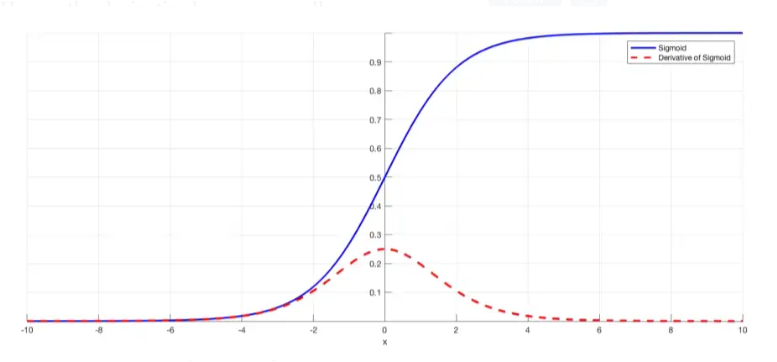

As we can see when the input of the sigmoid function becomes larger or smaller, the derivative becomes close to zero.

All sigmoid functions are monotonic and have a bell-shaped first derivative. There are several sigmoid functions and some of the best-known are presented below:

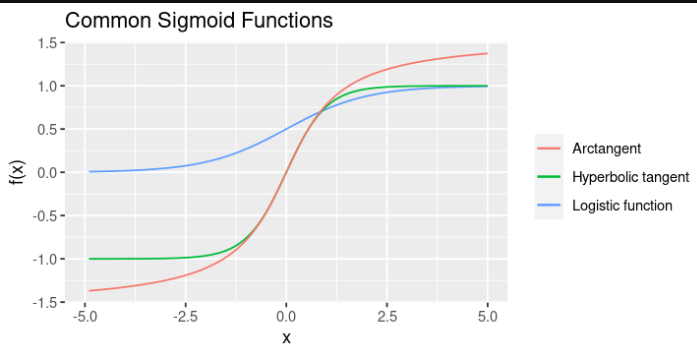

### Logestic tangent function formula
the logestic function takes any real valued input, and outputs a value between zero and one. 



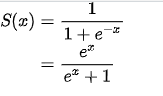

### Hyperbolic Tangent Function Formula

this maps any real valued input to the range between -1 and 1

### Arctangent Function Formula

the arctangent function maps any real valued input to the range -pi/2 to pi/2.


When the number of layers in the neural network is huge, it can cause the gradient to be too small for training to work effectively.
Gredients of neural network are found using backpropagation. It finds the derivatives of the network by moving layer by layer from the final layer to the initial one.By the chain rule, the derivatives of each layer are multiplied down the network (from the final layer to the initial) to compute the derivatives of the initial layers.
However, when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together. Thus, the gradient decreases exponentially as we propagate down to the initial layers.
A small gradient means that the weights and biases of the initial layers will not be updated effectively with each training session. Since these initial layers are often crucial to recognizing the core elements of the input data, it can lead to overall inaccuracy of the whole network.


## Solution of vanishing gradient problem
To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.


In [73]:
%%time 
with strategy.scope():
    # the first layer is an embedding layer. this layer converts the input integers (which represent words) into dense vectors of fixed size (300) 
    model.add(Embedding(len(word_index)+1, 300, 
                        weights=[embedding_matrix], # The embedding matrix (weights) is initialized with pre-trained GloVe 
                        input_length=max_len,
                        trainable=False))
    
    model.add(SpatialDropout1D(0.3)) # The second layer is a SpatialDropout1D layer. This layer randomly sets input units to 0 with a frequency of rate at each step during training time. which help prevent overfitting. 30% of the input units will be set to 0.
    model.add(GRU(300)) # the third layer is s GRU layer, a gated recurrent unit layer used for processing seauential data. the number of units in the layer is 300.
    model.add(Dense(1, activation='sigmoid'))  # The fourth layer is a Dense layer, a sigmoid activation function. with 1 output.
    
    # the model is compiled with a binary_crossentropy loss function which is commonly used for binary classification problens and adam optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           6810300   
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
 embedding_5 (Embedding)     (None, 1, 300)            6810300   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1, 300)           0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 300)               541800    
                                                      

In [74]:
model.fit(xtrain_pad, ytrain, epochs=10, batch_size=64*strategy.num_replicas_in_sync)


Epoch 1/10
96/96 [==============================] - 5s 28ms/step - loss: 0.6853 - accuracy: 0.5703
Epoch 2/10
96/96 [==============================] - 3s 27ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 3/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6837 - accuracy: 0.5703
Epoch 4/10
96/96 [==============================] - 2s 26ms/step - loss: 0.6836 - accuracy: 0.5703
Epoch 5/10
96/96 [==============================] - 3s 26ms/step - loss: 0.6832 - accuracy: 0.5703
Epoch 6/10
96/96 [==============================] - 2s 25ms/step - loss: 0.6840 - accuracy: 0.5703
Epoch 7/10
96/96 [==============================] - 3s 28ms/step - loss: 0.6835 - accuracy: 0.5703
Epoch 8/10
96/96 [==============================] - 3s 28ms/step - loss: 0.6838 - accuracy: 0.5703
Epoch 9/10
96/96 [==============================] - 3s 28ms/step - loss: 0.6833 - accuracy: 0.5703
Epoch 10/10
96/96 [==============================] - 3s 29ms/step - loss: 0.6834 - accuracy: 0.5703


In [70]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

48/48 [==============================] - 1s 12ms/step
Auc: 0.50%


# Attention Models
